In [3]:
# Connect to Google drive
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

import os
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import img_to_array

In [5]:
# print(os.listdir("/content/gdrive/MyDrive/HOTimages"))

SIZE = 256

In [6]:
# Getting training images, sorting and converting to numpy array
training_images = glob.glob("/content/gdrive/MyDrive/HOTimages/training_images_1/*.tif")
training_images.sort()

images = [cv2.imread(image, 1) for image in training_images]
image_dataset = np.array(images)
# image_dataset = np.expand_dims(image_dataset, axis = 3)

In [7]:
# Getting training masks, sorting and converting to numpy array
training_masks = glob.glob("/content/gdrive/MyDrive/HOTimages/training_masks_1/*.tif")
training_masks.sort()

masks = [cv2.imread(mask, 0) for mask in training_masks]
mask_dataset = np.array(masks)

In [8]:
print("Total images in the original dataset are: ", len(training_images))
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Total images in the original dataset are:  32
Image data shape is:  (32, 256, 256, 3)
Mask data shape is:  (32, 256, 256)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [9]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
n, h, w = mask_dataset.shape
mask_dataset_reshaped = mask_dataset.reshape(-1, 1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
mask_dataset_encoded = mask_dataset_reshaped_encoded.reshape(n, h, w)

np.unique(mask_dataset_encoded)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1])

In [10]:
# Normalize images
image_dataset = image_dataset / 255.0

In [12]:
# Split training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    image_dataset, mask_dataset_encoded, test_size=0.2, random_state=123
)

In [13]:
from keras.models import Model
from keras.applications.vgg16 import VGG16

# Load VGG16 model without classifier/fully connected layers

VGG_model = VGG16(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))

# Layers are non-trainable
for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [15]:
# Using only first 2 conv layers
new_model = Model(
    inputs=VGG_model.input, outputs=VGG_model.get_layer("block1_conv2").output
)
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [16]:
# Extract features from convolutional layers
features = new_model.predict(X_train)

1/1 [==============================] - 2s 2s/step


In [17]:
# Reassign 'features' as X
X = features

# Reshape X to match with labels that can be used for Random forest model
X = X.reshape(-1, X.shape[3])
print(X.shape)

(1638400, 64)


In [18]:
# Reshape Y to match X
Y = y_train.reshape(-1)
print(Y.shape)

(1638400,)


In [19]:
np.unique(Y)

array([0, 1])

In [32]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10, random_state=123)

In [33]:
# Train the model on training data
model.fit(X, Y)

RandomForestClassifier(n_estimators=10, random_state=123)

In [34]:
# Save model for future use
import pickle

filename = "/content/gdrive/MyDrive/HOTimages/model_RF.sav"

In [35]:
pickle.dump(model, open(filename, "wb"))

In [36]:
# Load model
loaded_model = pickle.load(open(filename, "rb"))

In [37]:
# Prediction
X_test_features = new_model.predict(X_test)
X_test_features = X_test_features.reshape(-1, X_test_features.shape[3])
print(X_test_features.shape)

1/1 [==============================] - 0s 496ms/step
(458752, 64)


In [38]:
# Predict using trained RF model
y_pred = loaded_model.predict(X_test_features)
print(y_pred.shape)

(458752,)


In [39]:
test_labels = y_test.reshape(-1)
print(test_labels.shape)

(458752,)


In [40]:
# Accuracy
from sklearn import metrics

print("Accuracy = ", metrics.accuracy_score(test_labels, y_pred))

Accuracy =  0.9738551548549107


In [41]:
# IOU
from keras.metrics import MeanIoU

# Using built in keras function
# from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_labels, y_pred)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7582245


1/1 [==============================] - 0s 77ms/step


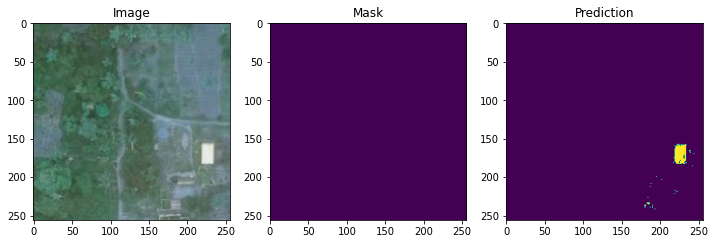

In [44]:
import random

img_number = random.randint(0, len(X_test) - 1)
img = X_test[img_number]
img = np.expand_dims(img, axis=0)

img_features = new_model.predict(img)
img_features = img_features.reshape(-1, img_features.shape[3])
mask = y_test[img_number]

prediction = loaded_model.predict(img_features)
predicted_mask = prediction.reshape(mask.shape[0], mask.shape[1])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Image")
plt.imshow(img[0], cmap="gray")
plt.subplot(232)
plt.title("Mask")
plt.imshow(mask)
plt.subplot(233)
plt.title("Prediction")
plt.imshow(predicted_mask)
plt.show()

1/1 [==============================] - 0s 78ms/step


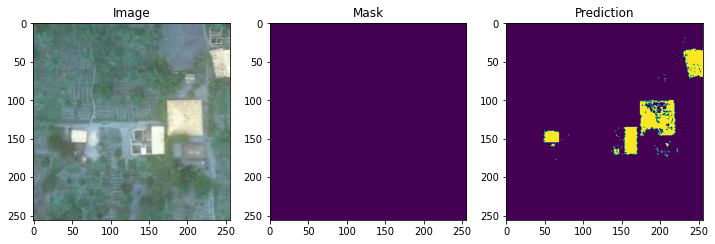

In [46]:
img_number = random.randint(0, len(X_test) - 1)
img = X_test[img_number]
img = np.expand_dims(img, axis=0)

img_features = new_model.predict(img)
img_features = img_features.reshape(-1, img_features.shape[3])
mask = y_test[img_number]

prediction = loaded_model.predict(img_features)
predicted_mask = prediction.reshape(mask.shape[0], mask.shape[1])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title("Image")
plt.imshow(img[0], cmap="gray")
plt.subplot(232)
plt.title("Mask")
plt.imshow(mask)
plt.subplot(233)
plt.title("Prediction")
plt.imshow(predicted_mask)
plt.show()